### **SET UP THE ENVIRONMENT**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import sys
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import datetime as dt

# Data Loading

Here the comments that have been separated by topic have been loaded from the csv files we have saved. These are then loaded into datasets which we will use further on into exploratory data analysis.

In [ ]:
guncontrol_comments_path = 'guncontrol_comments.csv'
minority_comments_path = 'minority_comments.csv'

# Load data into DataFrames
guncontrol_df = pd.read_csv(guncontrol_comments_path)
minority_df = pd.read_csv(minority_comments_path)

Before starting any kind of processing, the dataset is checked if it includes any missing values or not, and it can be seen that the content column which is the column that consist of the comments have some missing values. Which is strange, since the collected data is supposed to be only comments filtered out by length. However, we will just remove the NaN values and continue instead of imputing of any kind since these kinds of data require such way to deal with missing values, and they are very few considering datasets dimensions.

In [ ]:
df_list = [guncontrol_df, minority_df]

for df in df_list:
    print(df.isnull().sum())


id             0
author         0
link_id        0
parent_id      0
content      597
created        0
dtype: int64
id             0
author         0
link_id        0
parent_id      0
content      439
created        0
dtype: int64


In [ ]:
guncontrol_df = guncontrol_df.dropna()
minority_df = minority_df.dropna()

newdf_list = [guncontrol_df, minority_df]

for df in newdf_list:
    print(df.isnull().sum())



id           0
author       0
link_id      0
parent_id    0
content      0
created      0
dtype: int64
id           0
author       0
link_id      0
parent_id    0
content      0
created      0
dtype: int64


Now the datasets seem good to continue working on.

# EDA

### Basic Statistics
- **Gun Control Dataset**: Contains 59,119 comments from 13,428 unique authors. The dataset shows a significant engagement, with comments distributed across 817 different threads.
- **Minority Discrimination Dataset**: Comprises 31,017 comments from 18,062 unique authors, indicating a wide range of participation across 545 threads.

In [ ]:
# Summarize basic statistics
for df in newdf_list:
    print(df.describe())

             id            author    link_id  parent_id content  \
count     59119             59119      59119      59119   59119   
unique    59119             13428        817      34791   57302   
top     dg9y0yg  StonerMeditation  t3_8cg00s  t3_b32a3z     yes   
freq          1               528        860        169      56   

                    created  
count                 59119  
unique                58943  
top     2019-04-08 18:03:09  
freq                      3  
             id           author    link_id  parent_id content  \
count     31017            31017      31017      31017   31017   
unique    31017            18062        545      13787   29392   
top     f96bfdy  princesspuppy12  t3_7op2xi  t3_aubx9k   thank   
freq          1              106        637        331      71   

                    created  
count                 31017  
unique                30876  
top     2019-07-11 22:49:57  
freq                      3  


### Content Overview
- **Gun Control**: The dataset has over 1.19 million total words with 44,565 unique words, suggesting diverse and extensive discussions.
- **Minority Discrimination**: Contains approximately 464,598 total words with 29,153 unique words, highlighting substantial but more focused discourse.

In [ ]:
def word_count_analysis(df):
    word_counts = df['content'].str.split().apply(len)
    total_words = word_counts.sum()
    unique_words = len(set(' '.join(df['content']).split()))
    return word_counts, total_words, unique_words


gc_word_counts, gc_total_words, gc_unique_words = word_count_analysis(guncontrol_df)
mn_word_counts, mn_total_words, mn_unique_words = word_count_analysis(minority_df)

print(f"Gun Control: Total words = {gc_total_words}, Unique words = {gc_unique_words}")
print(f"Minority: Total words = {mn_total_words}, Unique words = {mn_unique_words}")


Gun Control: Total words = 1198540, Unique words = 44565
Minority: Total words = 464598, Unique words = 29153


## Data Shape
The shape of the data provides insights into the volume and structure of the datasets:
- **Gun Control Data Shape**: 59,119 rows × 7 columns.
- **Minority Data Shape**: 31,017 rows × 7 columns.
- **Combined Data Shape**: 90,136 rows × 7 columns.

Each dataset is labeled with its respective source to facilitate identification. The datasets are then concatenated into a single DataFrame to enable comprehensive analysis. The 'created' column is converted to datetime format to support time-based analysis.

In [ ]:
# Add a column to each dataset to identify its source
guncontrol_df['dataset'] = 'Gun Control'
minority_df['dataset'] = 'Minority'


# Concatenate the datasets
combined_df = pd.concat([guncontrol_df, minority_df], ignore_index=True)

# Convert 'created' column to datetime
combined_df['created'] = pd.to_datetime(combined_df['created'])

# Basic Data Exploration
print(f"Gun Control Data Shape: {guncontrol_df.shape}")
print(f"Minority Data Shape: {minority_df.shape}")

print(f"Combined Data Shape: {combined_df.shape}")
print(combined_df.info())

# Descriptive Statistics
combined_df['word_count'] = combined_df['content'].apply(lambda x: len(word_tokenize(x)))
combined_df['char_count'] = combined_df['content'].apply(lambda x: len(x))


Gun Control Data Shape: (59119, 7)
Minority Data Shape: (31017, 7)
Combined Data Shape: (90136, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90136 entries, 0 to 90135
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         90136 non-null  object        
 1   author     90136 non-null  object        
 2   link_id    90136 non-null  object        
 3   parent_id  90136 non-null  object        
 4   content    90136 non-null  object        
 5   created    90136 non-null  datetime64[ns]
 6   dataset    90136 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 4.8+ MB
None


/var/folders/7m/5f7_bfj94273yyprk3hx9ch00000gn/T/ipykernel_15411/866609603.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  guncontrol_df['dataset'] = 'Gun Control'
/var/folders/7m/5f7_bfj94273yyprk3hx9ch00000gn/T/ipykernel_15411/866609603.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  minority_df['dataset'] = 'Minority'


## Character and Word Count Analysis


### Distribution of Character Count per Comment
The distribution of character counts in comments is heavily skewed towards shorter comments, with most comments being under 200 characters. This trend suggests that discussions are generally concise, possibly indicating the use of brief statements or opinions rather than detailed arguments.

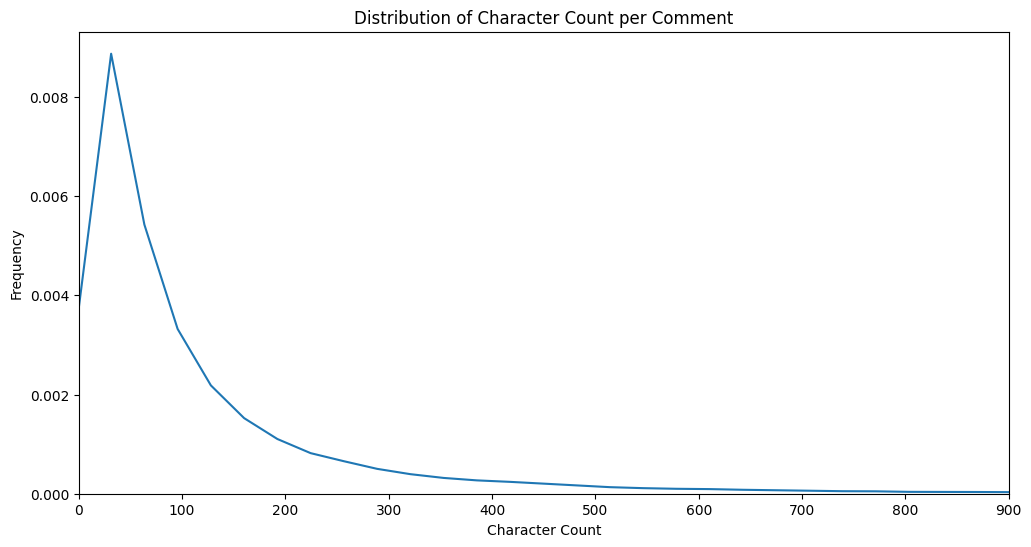

In [ ]:
plt.figure(figsize=(12, 6))
#sns.histplot(combined_df['char_count'], bins=30, kde=True)
sns.kdeplot(combined_df['char_count'], bw_adjust=0.5)
plt.xlim(0, 900)
plt.title('Distribution of Character Count per Comment')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.show()


The code uses a kernel density estimate (KDE) plot to display the distribution of character counts, with the bandwidth adjustment set to 0.5 for smoother visualization. The x-axis represents the character count, while the y-axis shows the frequency of comments with those character counts. The plot reveals that most comments have a relatively low character count, typically under 100 characters, with a sharp decline in frequency as the character count increases. This indicates that the majority of interactions within the social network are concise, with fewer extended comments. The distribution tailing off beyond 200 characters suggests that lengthy comments are relatively rare. This insight into comment length in terms of characters helps in understanding user engagement and interaction style within the network.

### Boxplot of Word Count per Comment by Dataset
The word count per comment, when compared across the 'Gun Control' and 'Minority' datasets, shows a similar distribution, with a majority of comments containing relatively few words and some outliers indicating a few verbose comments. This highlights that while most participants in these discussions prefer brevity, there are some who engage more extensively.

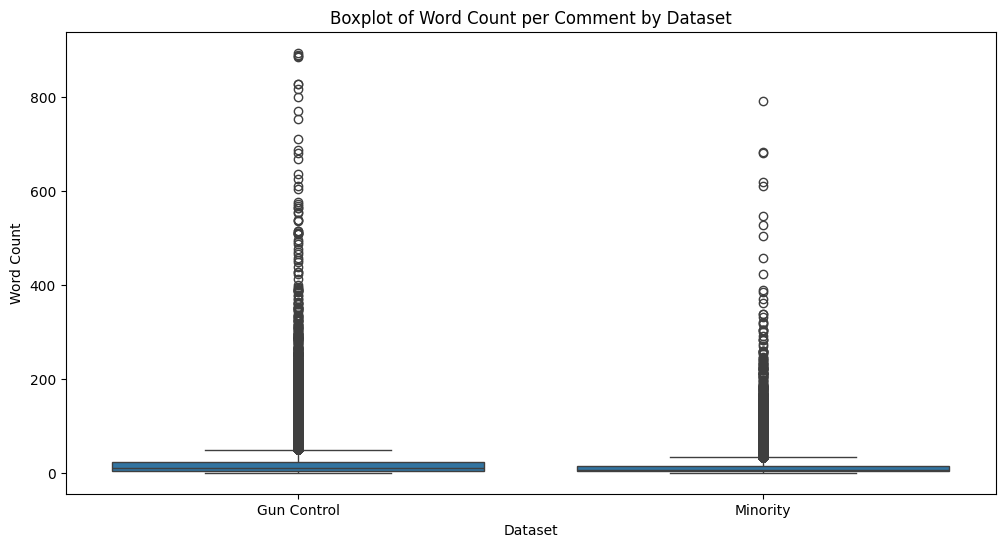

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='dataset', y='word_count', data=combined_df)
plt.title('Boxplot of Word Count per Comment by Dataset')
plt.xlabel('Dataset')
plt.ylabel('Word Count')
plt.show()


## Temporal Analysis of Comments

### Number of Comments Over Time
The number of comments over time shows periodic peaks and troughs, which might correlate with specific events or news cycles impacting public sentiment on gun control and minority issues. An upward trend in early 2020 could be explored further to understand its correlation with external events.

### Number of Comments by Hour of Day
Comments peak during late evening hours, suggesting that most commenting activity happens post-work hours, maybe when individuals have free time to engage in discussions.

### Number of Comments by Day of Week
The distribution of comments throughout the week is fairly uniform with slight increases on Mondays and Sundays. This could reflect a pattern where discussions spike as new developments occur and towards the end of the week when people have more leisure time to contribute to online discussions.

/var/folders/7m/5f7_bfj94273yyprk3hx9ch00000gn/T/ipykernel_15411/1741270610.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  combined_df.resample('M').size().plot()


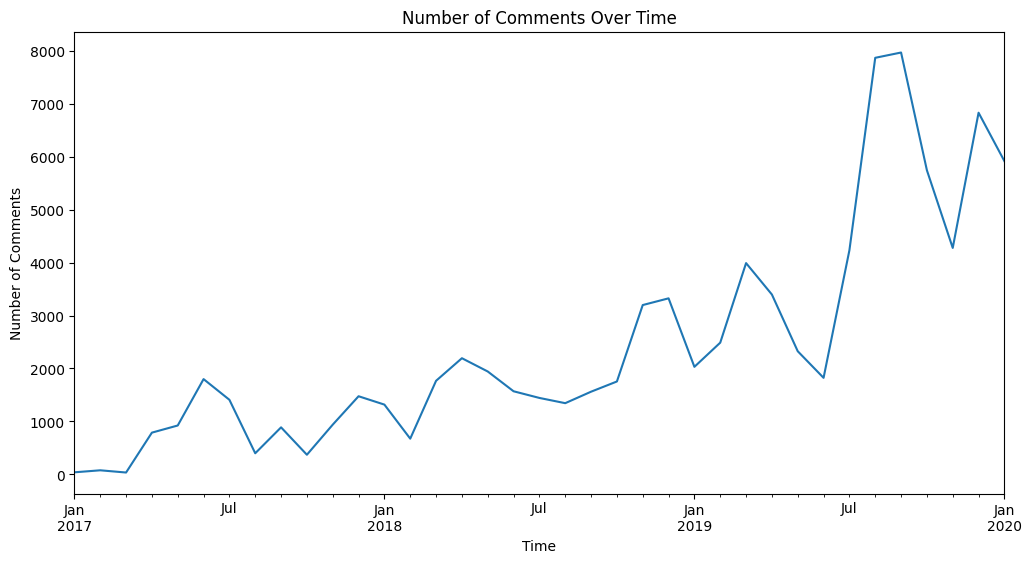

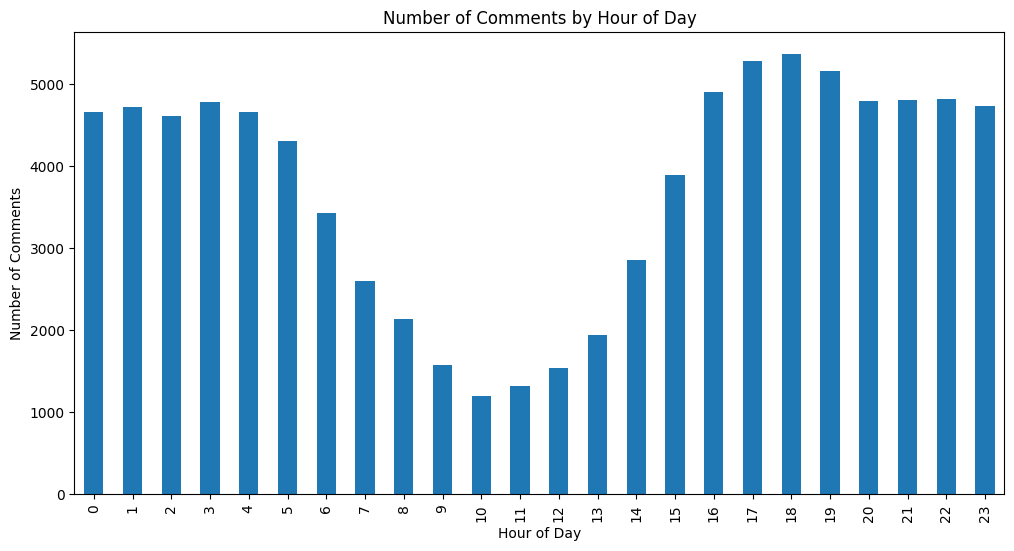

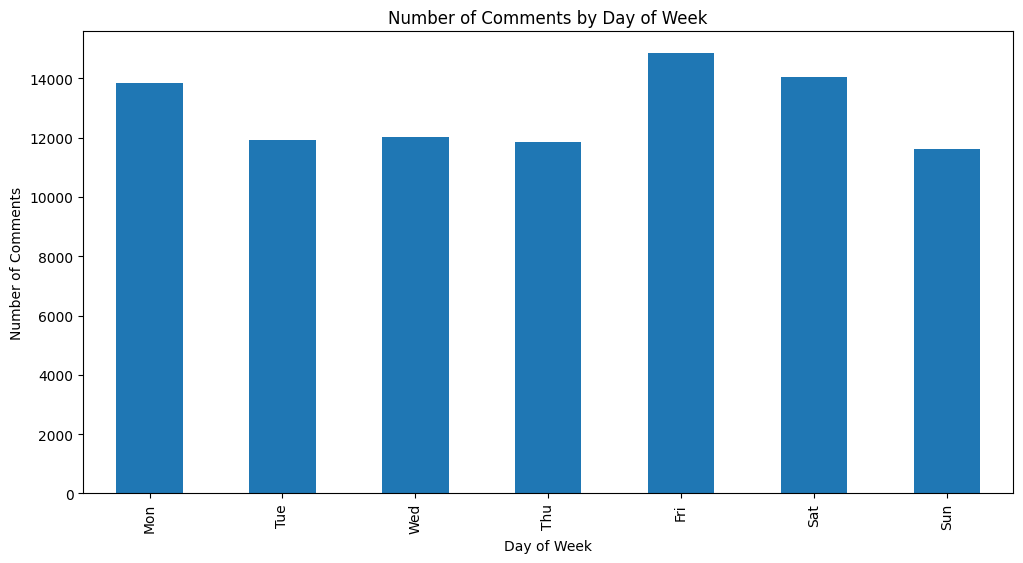

In [ ]:
# Temporal Analysis
combined_df.set_index('created', inplace=True)

plt.figure(figsize=(12, 6))
combined_df.resample('M').size().plot()
plt.title('Number of Comments Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Comments')
plt.show()

plt.figure(figsize=(12, 6))
combined_df.groupby(combined_df.index.hour).size().plot(kind='bar')
plt.title('Number of Comments by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Comments')
plt.show()

plt.figure(figsize=(12, 6))
combined_df.groupby(combined_df.index.dayofweek).size().plot(kind='bar')
plt.title('Number of Comments by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Comments')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()


## Analysis of Top Commenters

The top 20 commenters on these topics show significant engagement compared to others, with the highest contributor posting around 500 comments. This could indicate a small number of highly active individuals driving much of the conversation, which is common in online forums and discussions.

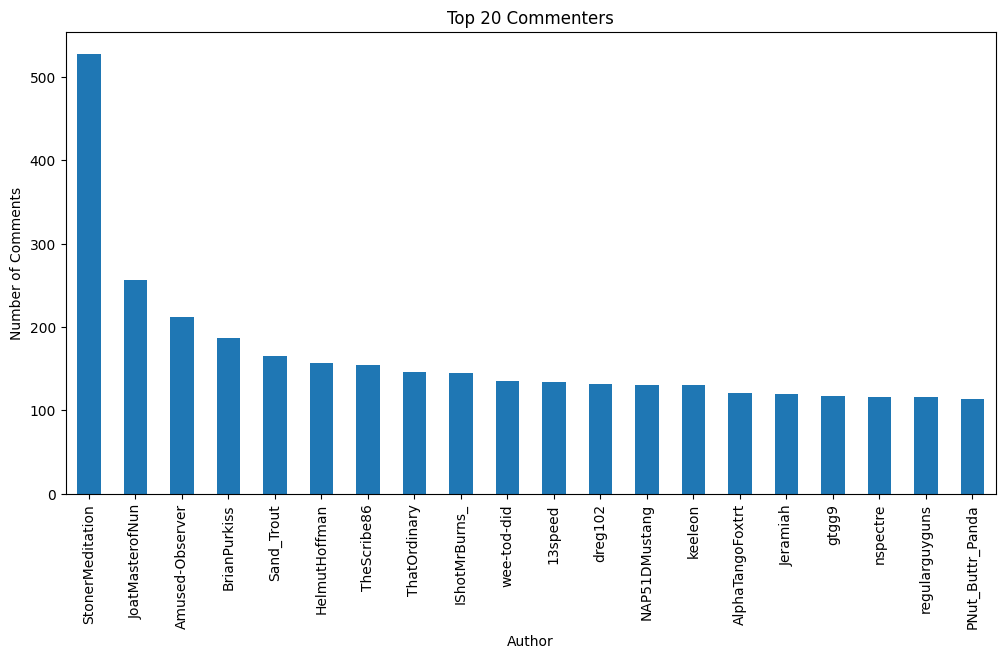

In [ ]:
# Author Analysis
top_commenters = combined_df['author'].value_counts().head(20)

plt.figure(figsize=(12, 6))
top_commenters.plot(kind='bar')
plt.title('Top 20 Commenters')
plt.xlabel('Author')
plt.ylabel('Number of Comments')
plt.show()


In [ ]:
# Save the combined dataset for further analysis if needed
combined_df.reset_index(inplace=True)
combined_df.to_csv('combined_comments.csv', index=False)

# Named Entity Recognition (NER) Analysis

### Overview
Named Entity Recognition (NER) was employed to identify and categorize key entities such as locations, organizations, dates, and personal names within the comments. This step helps us understand what specific elements are most frequently mentioned in discussions, giving insight into the focus points of each topic.

### Gun Control Entities
These entities suggest discussions are centered around policy, geography, and party politics, emphasizing the divisive and policy-oriented nature of the gun control debate.

In [ ]:
from collections import Counter

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

# Function to extract and count entities
def extract_and_count_entities(text_series):
    all_entities = []
    for doc in nlp.pipe(text_series, batch_size=1000):
        all_entities.extend([ent.text for ent in doc.ents])
    return Counter(all_entities).most_common(30)

# Extract and count entities for each topic
guncontrol_top_entities = extract_and_count_entities(guncontrol_df['content'])
minority_top_entities = extract_and_count_entities(minority_df['content'])

# Display the most frequent entities
print("Top 20 Gun Control Entities:")
for entity, count in guncontrol_top_entities:
    print(f"{entity}: {count}")

Top 20 Gun Control Entities:
one: 3958
first: 1736
second: 1129
two: 1063
american: 729
years: 629
americans: 609
democrats: 577
california: 509
america: 469
republicans: 422
today: 404
democrat: 359
republican: 354
texas: 347
congress: 339
million: 293
zero: 293
china: 291
fbi: 278
half: 272
three: 268
year: 262
supreme court: 262
cnn: 216
united states: 210
hong kong: 190
florida: 189
chinese: 185
third: 182


### Minority Discrimination Entities
This analysis shows that discussions around minority discrimination often revolve around identity, community, and social issues, highlighting the personal and community impacts of discrimination.


In [ ]:
print("\nTop 30 Minority Discrimination Entities:")
for entity, count in minority_top_entities:
    print(f"{entity}: {count}")


Top 30 Minority Discrimination Entities:
one: 1568
lgbt: 798
two: 778
first: 766
years: 334
christian: 280
christians: 198
second: 189
republican: 175
lesbian: 164
american: 163
today: 161
republicans: 133
half: 109
three: 103
year: 96
america: 94
english: 90
jesus: 89
years ago: 88
americans: 84
catholic: 82
democrats: 74
asian: 73
god: 73
russia: 67
months: 67
days: 65
christianity: 64
third: 61


# Sentiment Analysis

## Overview of Sentiment Distribution
Sentiment analysis reveals the overall emotional tone of comments across different datasets. By classifying comments as positive, neutral, or negative, we can gain insight into the general sentiment of public discussions on sensitive topics.

### General Sentiment Distribution
The overall sentiment distribution shows a higher prevalence of positive sentiments compared to neutral and negative. This suggests that, in general, discussions tend to have a more positive or supportive tone.

sentiment
Positive    37284
Negative    32142
Neutral     20710
Name: count, dtype: int64


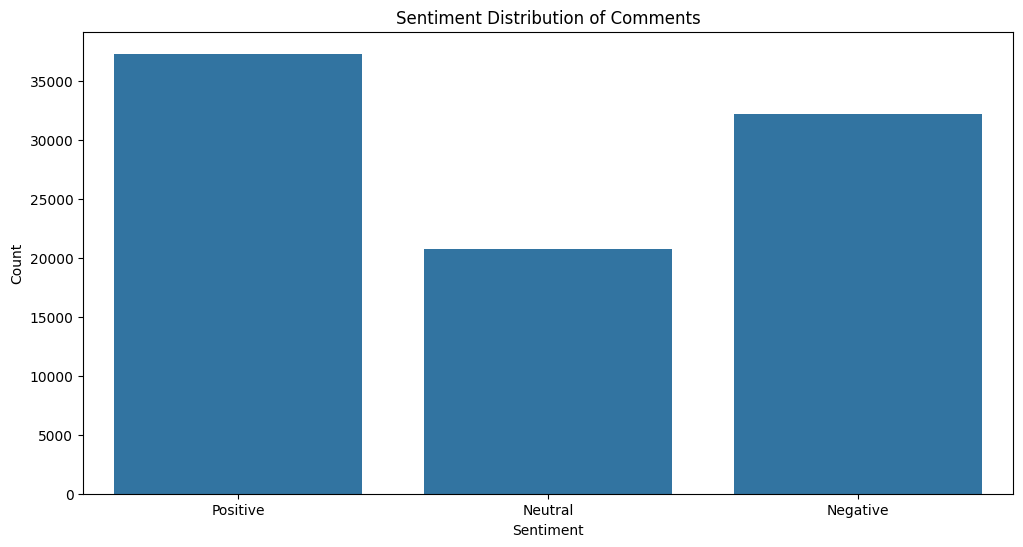

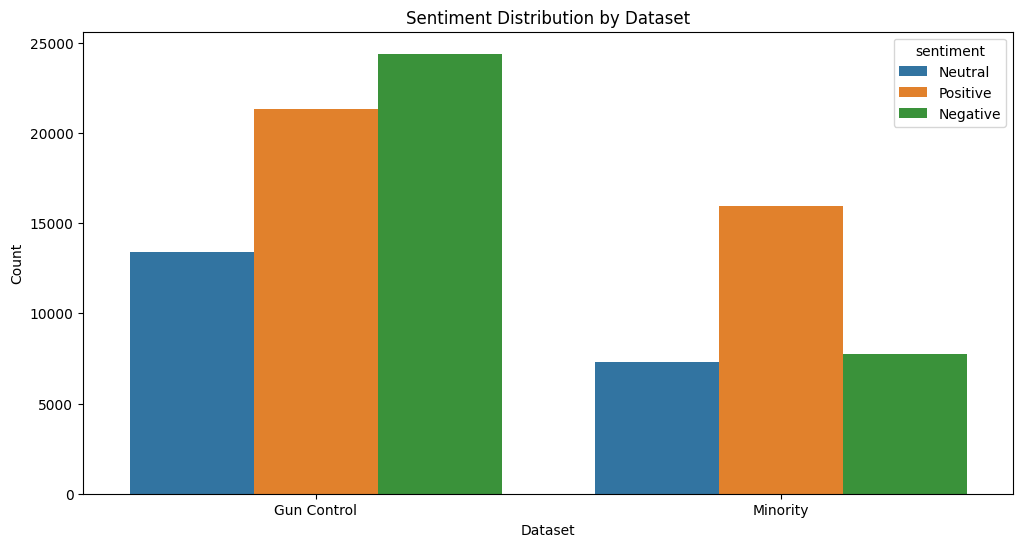

In [ ]:
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to classify sentiment
def classify_sentiment(text):
    score = analyzer.polarity_scores(text)
    if score['compound'] >= 0.05:
        return 'Positive'
    elif score['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment classification
combined_df['sentiment'] = combined_df['content'].apply(classify_sentiment)

# Display sentiment distribution
print(combined_df['sentiment'].value_counts())

# Visualization of Sentiment Distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='sentiment', data=combined_df, order=['Positive', 'Neutral', 'Negative'])
plt.title('Sentiment Distribution of Comments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Sentiment distribution by dataset
plt.figure(figsize=(12, 6))
sns.countplot(x='dataset', hue='sentiment', data=combined_df, order=['Gun Control', 'Minority'])
plt.title('Sentiment Distribution by Dataset')
plt.xlabel('Dataset')
plt.ylabel('Count')
plt.show()

# Save the dataset with sentiment labels
combined_df.to_csv('combined_comments_with_sentiment.csv', index=False)


### Sentiment Distribution by Dataset
When comparing sentiment across the 'Gun Control' and 'Minority' datasets:
- **Gun Control**: Displays a balanced distribution of sentiments with a substantial number of both positive and negative comments, indicating a polarized discussion.
- **Minority Discrimination**: Shows a dominance of neutral sentiments, suggesting a more reserved or cautious tone in discussions, with positive and negative sentiments being less pronounced.

These differences may reflect the nature of the discussions in each area, with gun control debates possibly being more contentious or divided, while discussions on minority issues might be more exploratory or tentative.


## Insights from Sentiment Analysis
The higher overall positive sentiment might indicate a prevailing hope or support towards the topics discussed. However, the significant number of negative sentiments in the gun control dataset suggests strong opposing views or concerns, highlighting the contentious nature of the debate.

The neutrality observed in minority discrimination discussions could indicate either a lack of consensus or a balanced perspective among participants. This requires further qualitative analysis to understand the subtleties of the discourse.